In [62]:
import os 
import sys
import time
import pandas as pd
import plotly.graph_objects as pl
import matplotlib.pyplot as plt
from IPython.display import clear_output
from dataclasses import dataclass
from dataclasses import field
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import pytz
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

In [2]:
"""" 
# Enter a stock symbol
import urllib.request
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

index = 'AAPL'
# URL link 
url_is = 'https://finance.yahoo.com/quote/' + index + '/financials?p=' + index
url_bs = 'https://finance.yahoo.com/quote/' + index +'/balance-sheet?p=' + index
url_cf = 'https://finance.yahoo.com/quote/' + index + '/cash-flow?p=' + index
from urllib.request import Request, urlopen
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
request = Request(url_is, headers=headers)
read_data = urlopen(request).read().decode()

soup_is= BeautifulSoup(read_data,'lxml')
ls= [] # Create empty list
for l in soup_is.find_all('div'): 
  #Find all data structure that is 'div'
  ls.append(l.string) # add each element one by one to the list
 
ls = [e for e in ls if e not in ('Operating Expenses','Non-recurring Events')] # Exclude those columns
new_ls = list(filter(None,ls))
new_ls = new_ls[12:]
is_data = list(zip(*[iter(new_ls)]*6))
Income_st = pd.DataFrame(is_data[0:])
Income_st.columns = Income_st.iloc[0] # Name columns to first row of dataframe
Income_st = Income_st.iloc[1:,] # start to read 1st row
Income_st = Income_st.T # transpose dataframe
Income_st.columns = Income_st.iloc[0] #Name columns to first row of dataframe
Income_st.drop(Income_st.index[0],inplace=True) #Drop first index row
Income_st.index.name = '' # Remove the index name
Income_st.rename(index={'ttm': '12/31/2019'},inplace=True) #Rename ttm in index columns to end of the year

"""

'" \n# Enter a stock symbol\nimport urllib.request\nfrom urllib.request import Request, urlopen\nfrom bs4 import BeautifulSoup\n\nindex = \'AAPL\'\n# URL link \nurl_is = \'https://finance.yahoo.com/quote/\' + index + \'/financials?p=\' + index\nurl_bs = \'https://finance.yahoo.com/quote/\' + index +\'/balance-sheet?p=\' + index\nurl_cf = \'https://finance.yahoo.com/quote/\' + index + \'/cash-flow?p=\' + index\nfrom urllib.request import Request, urlopen\nheaders = {\n    \'User-Agent\': \'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3\'}\nrequest = Request(url_is, headers=headers)\nread_data = urlopen(request).read().decode()\n\nsoup_is= BeautifulSoup(read_data,\'lxml\')\nls= [] # Create empty list\nfor l in soup_is.find_all(\'div\'): \n  #Find all data structure that is \'div\'\n  ls.append(l.string) # add each element one by one to the list\n \nls = [e for e in ls if e not in (\'Operating Expenses\',\'Non-recurring E

In [3]:
#Online Mean calculation dataclass
@dataclass
class Mean :
    n: float = 0
    value : float = 0

    def update(self, x):
        self.n += 1
        self.value += (x - self.value)/self.n

In [4]:
def compute_RSI(df, n):
    diff = df['Close'].diff()
    gain = diff.where(diff > 0, 0)
    loss = - diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window = 14).mean()
    avg_loss = loss.rolling(window =14).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1+rs))

In [5]:
def compute_bollinger_bands(df, window, no_std):

    """
    Computes values of Low and High Bollinger bands of the stock, which represent an interval in which the value of the stock is contained

    -------
    Arguments :

    df : dataframe
    window : time window for computing the values
    no_std : number of standard deviations used in calculation
    """


    rolling_mean = df['Close'].rolling(window).mean()
    rolling_std = df['Close'].rolling(window).std()
    df['Bollinger_High'] = rolling_mean + (rolling_std*no_std)
    df['Bollinger_Low'] = rolling_mean + (rolling_std*no_std)
    return df

In [6]:
#Exponential moving average dataclass
@dataclass
class EMA :
    """"
    Dataclass that computes and updates the Exponential Moving Average of the stock

    ----------
    Attributes:

    w : weight assigned to the new value
    ema : value of the current exponential moving average

    ---------
    Methods :
    
    update : updates the value of the exponential moving average
    reset : resets the value of the exponential moving average
    
    """

    w : float
    ema : float = 0

    def update(self, x):
        if self.ema == 0:
            self.ema = x
        else : 
            self.ema = self.w *x + (1-self.w)*self.ema

    def reset(self):
        self.ema = 0

In [7]:
#MinMax Scaler
scaler = MinMaxScaler(feature_range=(0,1))

In [59]:
#LSTM initialization
model = Sequential()

#First layer
model.add(LSTM(units = 50, return_sequences=True, input_shape = (8,1)))

#Second layer
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

#Third layer with dropout regularization
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(units = 1))

#Compilation
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

                    Datetime        Open        High         Low       Close  \
0  2023-01-03 09:30:00-05:00  130.279999  130.899994  125.230003  125.459999   
1  2023-01-03 10:30:00-05:00  125.459999  125.870003  124.730003  125.345001   
2  2023-01-03 11:30:00-05:00  125.350197  125.370003  124.349098  124.660004   
3  2023-01-03 12:30:00-05:00  124.660004  124.940002  124.190002  124.649902   
4  2023-01-03 13:30:00-05:00  124.669899  125.000000  124.190002  124.570000   

    Adj Close    Volume  RSI_14  Bollinger_High  Bollinger_Low          Time  
0  125.459999  27775505     0.0             0.0            0.0  8.660301e+06  
1  125.345001  18104999     0.0             0.0            0.0  8.656701e+06  
2  124.660004  11248777     0.0             0.0            0.0  8.653101e+06  
3  124.649902   8860080     0.0             0.0            0.0  8.649501e+06  
4  124.570000   8388062     0.0             0.0            0.0  8.645901e+06  
Epoch 1/100
11/11 [==========================

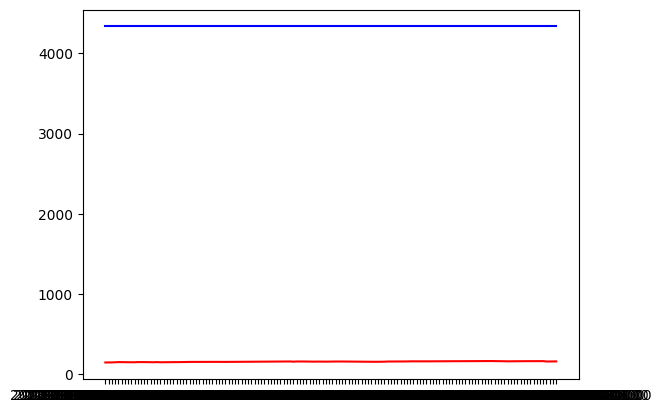

In [83]:
import os
import pandas as pd
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler


class MonitorFolder(FileSystemEventHandler):
    """
    Class for monitoring any changes in folder of the csv file 

    -----------
    Attributes :
        MAX_SIZE (int) : Size threshold in bytes for the folder or file for triggerring parallelization

    -----------
    Methods :

        on_created (event) : Prints message and calls checkFolderSize to check size of the folder when folder is created
        on_modified (event) : Prints a message and calls checkFolderSize to check size of the folder when folder is created
        on_deleted(event) : Prints a message when a file or folder is deleted
        checkFolderSize(src_path) : Checks the size of a file or folder and prints a message if the size exceeds MAX_SIZE

    https://medium.com/analytics-vidhya/monitoring-your-file-system-using-watchdog-64f7ad3279f

    """

    MAX_SIZE = 1000

    def checkFolderSize(self, src_path):
        if os.path.getsize(src_path) > self.MAX_SIZE:
            print("Directory getting big")
        else:
            if os.path.getsize(src_path) > self.MAX_SIZE:
                print("Very big file, commencing parallelization")

    def on_created(self, event):
        print(f"{event.src_path} was created")
        self.checkFolderSize(event.src_path)

    def on_modified(self, event):
        print(f"{event.src_path} was modified")
        self.checkFolderSize(event.src_path + "\\AAPL_prices.csv")

    def on_deleted(self, event):
        print(f"{event.src_path} was deleted")


if __name__ == "__main__":
    src_path = "C:\\Users\\lilib\\Documents\\Cours M2\\Big Data\\Data_Streaming_tse"

    event_handler = MonitorFolder()
    observer = Observer()
    observer.schedule(event_handler, path=src_path, recursive=True)
    print("Monitoring started")
    observer.start()


    try:
        while True:
            # Check if the CSV file exists before reading it
            if os.path.exists(src_path + "\\AAPL_prices.csv"):
                
                #Keep track of the last modification
                last_modification_time = os.path.getmtime(src_path + "\\AAPL_prices.csv")

                #Read dataframe
                df = pd.read_csv(src_path + "\\AAPL_prices.csv")

                #Define rolling mean object
                mean_obj = Mean(df['Close'])

                #Define EMA object and parameteres
                w = 0.5
                ema_obj = EMA(df['Close'], w)

                #Plot evolution of prices
                clear_output(wait = True)
                candlestick = pl.Candlestick(x = df.iloc[:, 0], low = df['Low'], high = df['High'], close = df['Close'], open = df['Open'])
                fig = pl.Figure(data=[candlestick])
                fig.show()

                #Compute 14-day RSI : Relative Strength index
                df['RSI_14'] = compute_RSI(df, 14)

                #Compute Bollinger Bands for 20 days for 2 standard deviations
                df = compute_bollinger_bands(df, 20, 2)
              
                #Update the rolling mean and exponential moving average if new line added
                if os.path.getmtime(src_path + "\\AAPL_prices.csv") != last_modification_time:
                    latest_close = df['Close'].iloc[-1]
                    mean_obj.update(latest_close)
                    ema_obj.update(latest_close, w)

                #Fill NaN's with 0s
                df = df.fillna(0)

                #Time feature : compute difference in seconds between now and all the dates
                date_diff = [(datetime.now(pytz.timezone('US/Eastern')) - datetime.fromisoformat(date)).total_seconds() for date in df.iloc[:,0]]
                df['Time'] = date_diff

                print(df.head())
                #Scaling the input data 
                scaled_data = scaler.fit_transform(df.iloc[:, 1:].drop('Close', axis = 1))
                scaled_df = pd.DataFrame(scaled_data, columns = df.iloc[:, 1:].columns[:-1])
                scaled_df['Close'] = df['Close']
                scaled_df['Date'] = df.iloc[:, 0]
                scaled_df['Time'] = df['Time']

                #Train-Test Split : using first 70% observations as training and 30% latest observations as test
                train_data = df.loc[:int(len(df))*0.7]
                test_data = df.loc[int(len(df)*0.7):]

                X_train = train_data.drop(['Datetime','Close', 'Adj Close'], axis = 1)
                y_train = train_data['Close']
                X_test = test_data.drop(['Datetime','Close', 'Adj Close'], axis = 1)
                y_test = test_data['Close']

                #Model fitting
                model.fit(X_train, y_train, epochs = 100, batch_size = 32)

                #Prediction and inversing normalization of results
                price_prediction = model.predict(X_test)[:,-1, 0]
                y_min = train_data['Close'].min()
                y_max = train_data['Close'].max()
                price_prediction = price_prediction * (y_max - y_min) + y_min


                #Evaluation : metrics
                print("Mean Squared Error :", mean_squared_error(y_test, price_prediction))
                print("Mean Absolute Error :", mean_absolute_error(y_test, price_prediction))
                print("R^2 score :", r2_score(y_test, price_prediction))

                #Results visualization
                plt.plot(df.loc[test_data.index, 'Datetime'], y_test, color = 'red', label = 'AAPL price')
                plt.plot(df.loc[test_data.index, 'Datetime'], price_prediction, color = 'blue', label = 'Predicted Price')



            time.sleep(10)

    except KeyboardInterrupt:
        observer.stop()
        observer.join()